In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
parquet_folder = "/content/"

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("PubMedData").getOrCreate()

In [ ]:
!ls '/content/drive/MyDrive/PubMedData/'

 df_selected.parquet		  parquet
 df_with_citations_list.parquet   pmid_citations_901.csv
'impact factor journals.xlsx'


In [ ]:
file_path = '/content/drive/MyDrive/PubMedData/parquet/pubmed25n0901.parquet'
df = spark.read.parquet(file_path)

In [ ]:
from pyspark.sql.functions import from_json, struct

json_schema_medline = spark.read.json(df.rdd.map(lambda row: row.MedlineCitation)).schema
json_schema_pubmed = spark.read.json(df.rdd.map(lambda row: row.PubmedData)).schema

df_parsed = df.withColumn("MedlineCitation", from_json("MedlineCitation", json_schema_medline)) \
              .withColumn("PubmedData", from_json("PubmedData", json_schema_pubmed))

df_parsed.printSchema()

root
 |-- MedlineCitation: struct (nullable = true)
 |    |-- @IndexingMethod: string (nullable = true)
 |    |-- @Owner: string (nullable = true)
 |    |-- @Status: string (nullable = true)
 |    |-- @VersionDate: string (nullable = true)
 |    |-- @VersionID: string (nullable = true)
 |    |-- Article: struct (nullable = true)
 |    |    |-- @PubModel: string (nullable = true)
 |    |    |-- Abstract: struct (nullable = true)
 |    |    |    |-- AbstractText: string (nullable = true)
 |    |    |    |-- CopyrightInformation: string (nullable = true)
 |    |    |-- ArticleDate: struct (nullable = true)
 |    |    |    |-- @DateType: string (nullable = true)
 |    |    |    |-- Day: string (nullable = true)
 |    |    |    |-- Month: string (nullable = true)
 |    |    |    |-- Year: string (nullable = true)
 |    |    |-- ArticleTitle: string (nullable = true)
 |    |    |-- AuthorList: struct (nullable = true)
 |    |    |    |-- @CompleteYN: string (nullable = true)
 |    |    |    

In [ ]:
from graphviz import Digraph

def generate_schema_graph(schema, graph, parent_node=None):
    for field in schema.fields:
        node_name = field.name  # Use only the field name

        graph.node(node_name, node_name, shape='box')

        if parent_node:
            graph.edge(parent_node, node_name)

        if isinstance(field.dataType, ArrayType) and isinstance(field.dataType.elementType, StructType):
            generate_schema_graph(field.dataType.elementType, graph, node_name)
        elif isinstance(field.dataType, StructType):
            generate_schema_graph(field.dataType, graph, node_name)

# Create separate graphs for MedlineCitation and PubmedData
dot_medline = Digraph(comment='MedlineCitation Schema')
dot_medline.attr(rankdir='TB', size='500')  # Vertical layout

dot_pubmed = Digraph(comment='PubmedData Schema')
dot_pubmed.attr(rankdir='TB', size='10')  # Vertical layout

# Generate schema graphs for each
generate_schema_graph(df_parsed.schema["MedlineCitation"].dataType, dot_medline, "MedlineCitation")
generate_schema_graph(df_parsed.schema["PubmedData"].dataType, dot_pubmed, "PubmedData")

# Render to separate files
dot_medline.render('/mnt/data/medline_citation_schema', format='svg', cleanup=False)
dot_pubmed.render('/mnt/data/pubmed_data_schema', format='svg', cleanup=False)

# Return paths to images
print(f"MedlineCitation Schema: /mnt/data/medline_citation_schema.svg")
print(f"PubmedData Schema: /mnt/data/pubmed_data_schema.svg")

MedlineCitation Schema: /mnt/data/medline_citation_schema.svg
PubmedData Schema: /mnt/data/pubmed_data_schema.svg


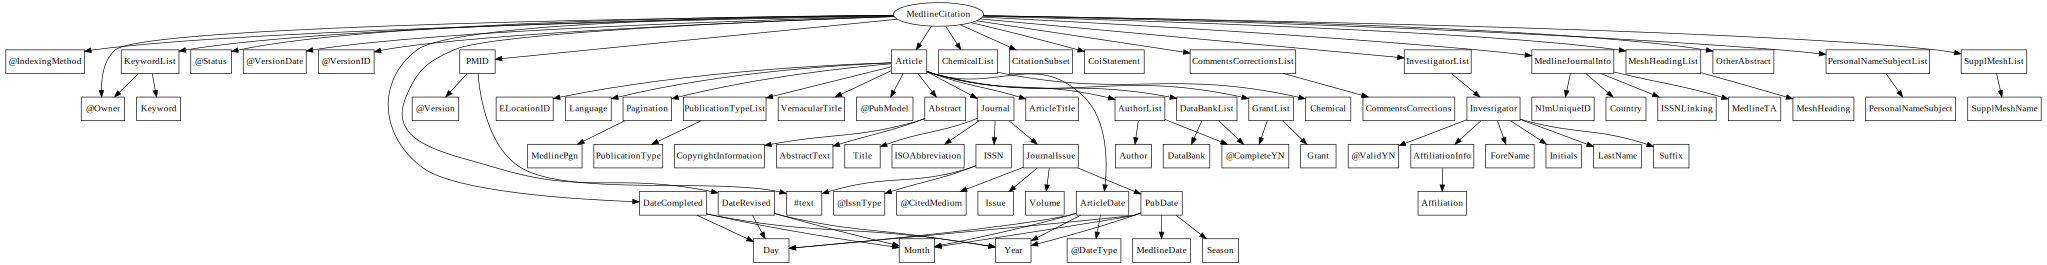

In [ ]:
from IPython.display import Image
from IPython.display import SVG

SVG(filename='/mnt/data/medline_citation_schema.svg')

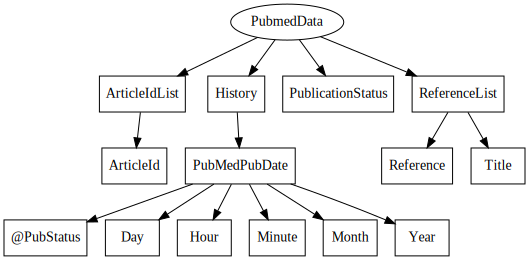

In [ ]:
SVG(filename='/mnt/data/pubmed_data_schema.svg')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("LoadParquet").getOrCreate()

parquet_path = "/content/drive/MyDrive/pubmed_data/df_pubmed.parquet"

df_pubmed = spark.read.parquet(parquet_path)

df_pubmed.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------+--------+----------------------+
|    PMID|               Title|            Abstract|Year|             Journal|     PublicationType|        Author_Names|            Keywords|        MeshHeadings|           Chemicals|          References|Reference_Count|             CitedBy|CitedBy_Count|     abstract_tokens|     keywords_tokens|         mesh_tokens|     chemical_tokens|      cleaned_tokens|      stemmed_tokens|BP_count|MF_count|CC_count|matched_go_terms_clean|
+------

In [ ]:
df_pubmed.columns

['PMID',
 'Title',
 'Abstract',
 'Year',
 'Journal',
 'PublicationType',
 'Author_Names',
 'Keywords',
 'MeshHeadings',
 'Chemicals',
 'References',
 'Reference_Count',
 'CitedBy',
 'CitedBy_Count',
 'abstract_tokens',
 'keywords_tokens',
 'mesh_tokens',
 'chemical_tokens',
 'cleaned_tokens',
 'stemmed_tokens',
 'BP_count',
 'MF_count',
 'CC_count',
 'matched_go_terms_clean']

In [ ]:
from pyspark.sql.functions import col
import pyspark.sql.functions as F

selected_columns = ['PMID', 'Title', 'Abstract', 'Year', 'Journal', 'Author_Names', 'Keywords', 'MeshHeadings', 'Chemicals', 'References']

# Assuming df_pubmed is your DataFrame
df_selected = df_pubmed.select(*[col(c) for c in selected_columns])

In [ ]:
df_selected.show(5)

+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    PMID|               Title|            Abstract|Year|             Journal|        Author_Names|            Keywords|        MeshHeadings|           Chemicals|          References|
+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|28299189|Molecular signatu...|Anastasis (Greek ...|2017|       F1000Research|[Ho Man Tang, C C...|[Anastasis, Cell ...|                NULL|                  []|[{Nat Rev Cancer....|
|28343686|Analysis of essen...|In the fields of ...|2017|Journal of chroma...|[Cecilia Cagliero...|[Essential oils, ...|[Allergens  [, an...|[Allergens, Ionic...|                  []|
|28343692|Quality survey of...|The aim of the pr...|2017|The Science of th...|[L

In [ ]:
from pyspark.sql.functions import col
import pyspark.sql.functions as F

selected_columns = ['PMID', 'Title', 'Abstract', 'Year', 'Journal', 'Author_Names', 'Keywords', 'MeshHeadings', 'Chemicals', 'References','CitedBy','CitedBy_count','matched_go_terms_clean','BP_count','MF_count','CC_count']

# Assuming df_pubmed is your DataFrame
df_selected = df_pubmed.select(*[col(c) for c in selected_columns])

In [ ]:
df_selected.show(5)

+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+----------------------+--------+--------+--------+
|    PMID|               Title|            Abstract|Year|             Journal|        Author_Names|            Keywords|        MeshHeadings|           Chemicals|          References|             CitedBy|CitedBy_count|matched_go_terms_clean|BP_count|MF_count|CC_count|
+--------+--------------------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+----------------------+--------+--------+--------+
|28299189|Molecular signatu...|Anastasis (Greek ...|2017|       F1000Research|[Ho Man Tang, C C...|[Anastasis, Cell ...|                NULL|                  []|[{Nat Rev Cancer....|[39015566,

In [ ]:
from pyspark.sql.functions import col
import pyspark.sql.functions as F

selected_columns = ['PMID', 'CitedBy_count','matched_go_terms_clean','BP_count','MF_count','CC_count']

# Assuming df_pubmed is your DataFrame
df_selected = df_pubmed.select(*[col(c) for c in selected_columns])

In [ ]:
df_selected.show(5,truncate=False)

+--------+-------------+----------------------------------------------------------------------------------------------------------+--------+--------+--------+
|PMID    |CitedBy_count|matched_go_terms_clean                                                                                    |BP_count|MF_count|CC_count|
+--------+-------------+----------------------------------------------------------------------------------------------------------+--------+--------+--------+
|28299189|36           |[{angiogenesis, 0.0}, {cell cycle, 0.0}, {cell death, 0.0}, {gene expression, 0.0}, {cell migration, 0.0}]|5       |0       |0       |
|28343686|3            |[{rent complex, 2.0}]                                                                                     |0       |0       |1       |
|28343692|5            |[{transport, 0.0}]                                                                                        |1       |0       |0       |
|28343695|10           |[{inflammatory respons